In [1]:
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as tts
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy as dp
import time 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import dataloader as dt
import allmodel as am
from scipy import signal as S
from torcheval.metrics.functional import multiclass_f1_score as f1
import utils
import train

In [2]:
ws=100
d = dt.Dataloader(ws,1)
d.split(['Person (1)','Person (2)','Person (3)'])
d.load()
d.binary_labels()


In [3]:
Data,DataC,label,relaxlabel,labelC,relaxlabelC,_,TestData,TestDataC,testlabel,testlabelC,testrelaxlabel,testrelaxlabelC,_ = d.fetch(10,ws,Gyro=False)

(2890328, 6)
Filtering Signal
Adding magnitude as feature
Data shape : torch.Size([2890328, 4])
Test Data shape :torch.Size([408364, 4])


In [4]:

ws1,we1,ws0,we0 = utils.count_imbalance(label,'cuda')
ws1r,we1r,ws0r,we0r = utils.count_imbalance(relaxlabel,'cuda')

print('True labels:\n',ws1.item(),we1.item(),ws0.item(),we0.item(),'\nRelaxed labels:\n',ws1r.item(),we1r.item(),ws0r.item(),we0r.item())

True labels:
 28.102909088134766 28.102909088134766 0.5090569853782654 0.5090569853782654 
Relaxed labels:
 1.4051510095596313 1.4051510095596313 0.7761970162391663 0.7761970162391663


In [5]:
channel = 4
batch_size=1024
# Create an instance of the LSTM network
#model = am.CNN2h(ws,channel,(1,channel,200)).cuda()
modelrelax = am.CNN2h(ws,channel,(1,channel,ws)).cuda()


In [6]:


# Create a DataLoader for batching
#dataset = torch.utils.data.TensorDataset(DataC[722582*0:722582*1].float().cuda(), labelC[722582*0:722582*1].float().cuda())
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

datasetrelax = torch.utils.data.TensorDataset(DataC[722582*0:722582*4].float().cuda(), relaxlabelC[722582*0:722582*4].float().cuda())
dataloaderrelax = torch.utils.data.DataLoader(datasetrelax, batch_size=batch_size, shuffle=True)

In [ ]:
#model,his = trainCNN2h(model,dataloader,ws0,we0,ws1,we1,lr=0.0001,epochs=5)

In [18]:
modelrelax,hisrelax =  train.trainCNN2h(modelrelax,dataloaderrelax,ws0r,we0r,ws1r,we1r,epochs=15,lr=0.0001)

Epoch 1/15 - Loss: 0.141851
Epoch 2/15 - Loss: 0.141239
Epoch 3/15 - Loss: 0.140763
Epoch 4/15 - Loss: 0.140251
Epoch 5/15 - Loss: 0.139820
Epoch 6/15 - Loss: 0.139409
Epoch 7/15 - Loss: 0.139018
Epoch 8/15 - Loss: 0.138716
Epoch 9/15 - Loss: 0.138355
Epoch 10/15 - Loss: 0.138015
Epoch 11/15 - Loss: 0.137730
Epoch 12/15 - Loss: 0.137483
Epoch 13/15 - Loss: 0.137226
Epoch 14/15 - Loss: 0.136959
Epoch 15/15 - Loss: 0.136755


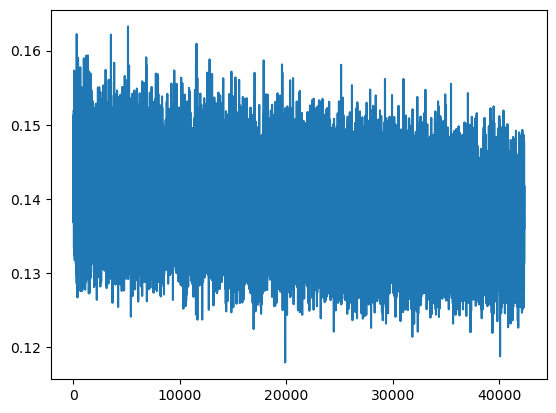

In [19]:
plt.plot(hisrelax)

In [32]:
#testpredictionwoc = get_prediction(model.eval().cpu(),TestData[102091*0:102091*1],200,8)
#trainpredictionwoc = get_prediction(model.eval().cpu(),Data,200,8)

In [20]:
relaxtestpredictionwoc = utils.get_prediction(modelrelax.eval().cpu(),TestData[102091*0:102091*4],ws,channel)
relaxtrainpredictionwoc = utils.get_prediction(modelrelax.eval().cpu(),Data[722582*0:722582*4],ws,channel)

In [21]:
#print('Test f1 accuracy: ',f1(testlabel[204182:306273:,0].cpu(),testpredictionwoc[:,0],num_classes=2),
#      f1(testlabel[204182:306273:,1].cpu(),testpredictionwoc[:,1],num_classes=2))

print('Test f1 accuracy relaxed: ',f1(testrelaxlabel[102091*0:102091*4,0].cpu(),relaxtestpredictionwoc[:,0],num_classes=2),
      f1(testrelaxlabel[102091*0:102091*4,1].cpu(),relaxtestpredictionwoc[:,1],num_classes=2))

Test f1 accuracy relaxed:  tensor(0.8954) tensor(0.8927)


In [22]:
#print('train f1 accuracy: ',f1(label[:,0].cpu(),trainpredictionwoc[:,0],num_classes=2),
 #     f1(label[:,1].cpu(),trainpredictionwoc[:,1],num_classes=2))

print('train f1 accuracy relax: ',f1(relaxlabel[722582*0:722582*4,0].cpu(),relaxtrainpredictionwoc[:,0],num_classes=2),
      f1(relaxlabel[722582*0:722582*4,1].cpu(),relaxtrainpredictionwoc[:,1],num_classes=2))

train f1 accuracy relax:  tensor(0.9502) tensor(0.9494)


In [ ]:
for i in range(22000,22150):
    plt.plot(TestData[i:i+200,3])
    plt.plot(relaxtestpredictionwoc[i:i+ws,0].detach().numpy(),color='r')
    #plt.plot(relaxlabel[(102091*0)+i:((102091*0)+i)+200,0].detach().numpy(),color='g')
    #plt.plot(testpredictionwoc[i:i+200,0].detach().numpy(),color='b')
    #plt.plot(midpoints[i:i+200,0].detach().numpy())
    plt.plot(testlabel[(102091*0)+i:((102091*0)+i)+ws,0])
    plt.show()
    clear_output(wait=True)

In [23]:
midpoints = utils.find_midpoints(relaxtestpredictionwoc)
P_s_index,P_e_index = utils.indexes(midpoints)
T_s_index,P_e_index = utils.indexes(testlabel)

In [30]:
mae,percentage,count,hist = utils.avg_distance(T_s_index,P_s_index,16)

In [31]:
hist

tensor([1458., 2456., 1741., 1043.,  518.,  248.,  150.,  103.,   73.,   58.,
          45.,   33.,   22.,   26.,   25.,   19.])

(tensor(2.1397), 0.9468587623996221, 8018, 8468)

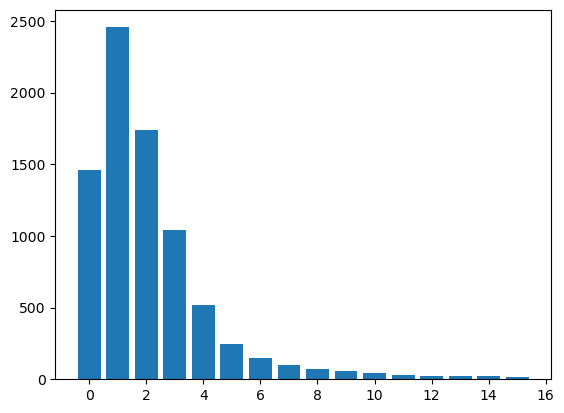

In [32]:
plt.bar(range(len(hist)),hist)
mae,percentage,count,8468

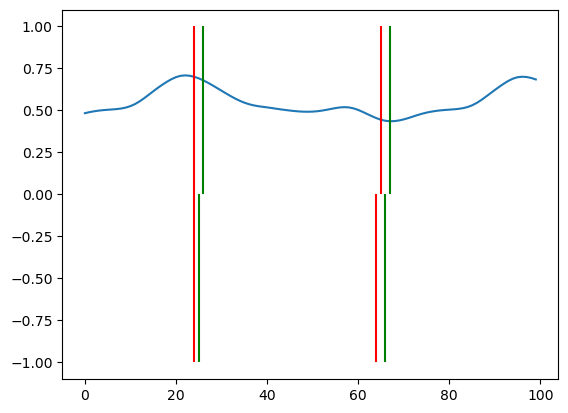

In [17]:
for i in range(1500,2000):
    plt.plot(Data[i:i+ws,2])
    plt.vlines(torch.where(midpoints[i:i+ws,0])[0],0,1,color='red')
    plt.vlines(torch.where(testlabel[i:i+ws,0])[0],0,1,color='green')
    plt.vlines(torch.where(midpoints[i:i+ws,1])[0],0,-1,color='red')
    plt.vlines(torch.where(testlabel[i:i+ws,1])[0],0,-1,color='green')
    plt.show()
    clear_output(wait=True)